In [1]:
import pandas as pd

from edgedroid.data.load import load_default_exec_time_data

_, _, imp_bins, _ = load_default_exec_time_data()
imp_bins[-1]

Interval(3.1982650678242854, inf, closed='left')

In [2]:
ttfs = (("low", 0), ("high", 3.2))
startup_window = 20
num_samples = 5000

In [3]:
from edgedroid.models.timings import *
import itertools as it
import numpy as np

results = pd.DataFrame(columns=["model", "neuroticism", "ttf", "exec_time"], index=np.arange(0, 8 * num_samples))
current_idx = -1

for mcls, neuroticism, (ttf_tag, ttf) in it.product((TheoreticalExecutionTimeModel, EmpiricalExecutionTimeModel), (0.0, 1.0), ttfs):
    model = mcls.from_default_data(neuroticism=neuroticism)
    for _ in range(startup_window):
        model.advance(ttf)

    for _ in range(num_samples):
        current_idx += 1
        results.at[current_idx, "model"] = mcls.__name__
        results.at[current_idx, "neuroticism"] = "high" if neuroticism > 0.5 else "low"
        results.at[current_idx, "exec_time"] = float(model.get_execution_time())
        results.at[current_idx, "ttf"] = ttf_tag

        model.advance(ttf)


results["neuroticism"] = results["neuroticism"].astype(pd.CategoricalDtype(["low", "high"], ordered=True))
results["ttf"] = results["ttf"].astype(pd.CategoricalDtype(["low", "high"], ordered=True))
results["exec_time"] = results["exec_time"].astype(float)
results

,model,neuroticism,ttf,exec_time
0,TheoreticalExecutionTimeModel,low,low,4.901415
1,TheoreticalExecutionTimeModel,low,low,3.870279
2,TheoreticalExecutionTimeModel,low,low,5.202121
3,TheoreticalExecutionTimeModel,low,low,6.770600
4,TheoreticalExecutionTimeModel,low,low,2.921000
...,...,...,...,...
39995,EmpiricalExecutionTimeModel,high,high,4.981410
39996,EmpiricalExecutionTimeModel,high,high,3.683843
39997,EmpiricalExecutionTimeModel,high,high,11.390658
39998,EmpiricalExecutionTimeModel,high,high,4.196024


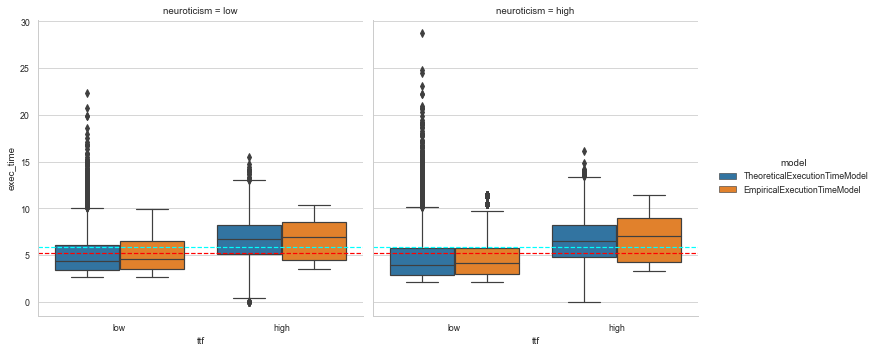

In [6]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("paper")
sns.set_style("whitegrid")

naive_model = ConstantExecutionTimeModel.from_default_data()
naive_exec_time = naive_model.get_execution_time()

prob_naive_model = NaiveExecutionTimeModel.from_default_data()
prob_naive_exec_time = prob_naive_model.get_expected_execution_time()


fg = sns.catplot(
    kind="box",
    errorbar=("ci", 95),
    data=results,
    hue="model",
    y="exec_time",
    x="ttf",
    col="neuroticism"
)
fg.refline(y=naive_exec_time, color="red")
fg.refline(y=prob_naive_exec_time, color="cyan")
plt.show()

In [5]:
(
    results
    .groupby(["neuroticism", "model", "ttf"])
    ["exec_time"]
    .describe()
)

count      mean       std  \
neuroticism model                         ttf                                
low         EmpiricalExecutionTimeModel   low   5000.0  5.140599  2.119424   
                                          high  5000.0  6.597932  2.352965   
            TheoreticalExecutionTimeModel low   5000.0  5.073122  2.321815   
                                          high  5000.0  6.709996  2.316123   
high        EmpiricalExecutionTimeModel   low   5000.0  4.885699  2.681627   
                                          high  5000.0  6.541900  2.478838   
            TheoreticalExecutionTimeModel low   5000.0  4.853743  2.785589   
                                          high  5000.0  6.548004  2.506315   

                                                     min       25%       50%  \
neuroticism model                         ttf                                  
low         EmpiricalExecutionTimeModel   low   2.724505  3.512730  4.618917   
                                          high  3.539722  4.544413  6.973581   
            TheoreticalExecutionTimeModel low   2.720033  3.390825  4.354679   
                                          high  0.000000  5.098060  6.702868   
high        EmpiricalExecutionTimeModel   low   2.181759  3.002960  4.125854   
                                          high  3.300936  4.233891  7.024530   
            TheoreticalExecutionTimeModel low   2.178297  2.934802  3.960426   
                                          high  0.000000  4.788820  6.533849   

                                                     75%        max  
neuroticism model                         ttf                        
low         EmpiricalExecutionTimeModel   low   6.561004   9.930327  
                                          high  8.505258  10.331286  
            TheoreticalExecutionTimeModel low   6.061877  22.292055  
                                          high  8.276116  15.544891  
high        EmpiricalExecutionTimeModel   low   5.739383  11.406472  
                                          high  8.988861  11.390658  
            TheoreticalExecutionTimeModel low   5.818236  28.754645  
                                          high  8.236508  16.182845